## Reading Input

In [ ]:
import pandas as pd
from proj_utils.input_interpreter import format_input

In [ ]:
customer_df = pd.read_excel('data/2_detail_table_customers.xls')
deposit_df = pd.read_excel('data/4_detail_table_depots.xls')
routes = customer_df['ROUTE_ID'].unique()

In [1]:
from proj_utils.fake_input_generator import generator
from proj_utils.input_interpreter import format_input

import matplotlib.pyplot as plt

from VRP.greedy_solutions import nearest_neighbour_solution
from VRP.modify_solution import combined_rand_modification
from VRP.verify_solution import valid_path, calculate_path_distance

from proj_utils.path import print_path

from solver_step import SolverStep
%matplotlib widget

# Simulated Annealing Solution

In [ ]:
import simulated_annealing.solver as SA # Simulated anealing solver

In [ ]:
#dists, demand, points = format_input(routes[2],customer_df,deposit_df)
dists, demand, points = generator(20)

In [ ]:
eval_function = lambda x: calculate_path_distance(x, dists) if(valid_path(x,(30,20),demand)) else float('inf')
solver_step = SA.generic_solver_factory(
    lambda x: combined_rand_modification(x, len(points)),
    eval_function,
    )

In [ ]:
init_state = nearest_neighbour_solution(dists, demand, (30,20))
init_step = SolverStep(init_state, eval_function(init_state),100)
step_1 = solver_step(init_step)
print(step_1.get_best_sol())
print(step_1.get_best_sol_value())

In [ ]:
step = step_1

In [ ]:
step = solver_step(step)
print(step.get_best_sol())
print(step.get_best_sol_value())

# Taboo Search

In [ ]:
import taboo_search.solver as TS

In [ ]:
dists, demand, points = generator(20)

In [ ]:
taboo_list_size = 10
solver_step = TS.taboo_search_solver_factory(
    lambda x: combined_rand_modification(x, len(points)),
    lambda x: calculate_path_distance(x, dists) if(valid_path(x,(30,20),demand)) else float('inf'),
    taboo_list_size
    )

In [ ]:
init_state = nearest_neighbour_solution(dists, demand, (30,20))
init_step = SolverStep(init_state, eval_function(init_state),2)
step_1 = solver_step(init_step)
print(step_1.get_best_sol())

In [ ]:
step = step_1

In [ ]:
step = solver_step(step)
print(step.get_best_sol())
print(step.get_best_sol_value())

# TEST Q-learning

In [2]:
def init_q_learning_table(q_size):
    return [[ 0 for _ in range(q_size)] for _ in range(q_size)]

In [3]:
import random
from dataclasses import dataclass
@dataclass(init=True)
class q_learning_obj:
    q_state: int
    q_table: list[list[float]]
    q_size: int
    discount_rate: float
    learning_rate: float

def epsilon_greedy(epsilon, q):
    p = random.random()
    if(p<=epsilon):
        return min(int(random.random()*(q.q_size)),q.q_size)
    else:
        return q.q_table[q.q_state].index(max(q.q_table[q.q_state]))

def q_learning_neighbour(path,q, neighbour_function_list, eval_function ,epsilon = 0.8):
    new_action = epsilon_greedy(epsilon, q)
    new_path = neighbour_function_list[new_action](path)
    r = eval_function(path) - eval_function(new_path)

    q.q_table[q.q_state][new_action] = ((1-q.learning_rate)*q.q_table[q.q_state][new_action]) + (q.learning_rate*(r+(q.discount_rate*max(q.q_table[q.q_state]))))
    q.q_state = new_action
    
    return new_path

In [4]:
from VRP.greedy_solutions import nearest_neighbour_solution
from VRP.modify_solution_routes import remove_smallest_route
from VRP.modify_solution_routes import remove_random_route
from VRP.modify_solution_routes import split_biggest_route
from VRP.modify_solution_routes import split_random_route
from VRP.modify_solution import rand_opt_n
from VRP.modify_solution import rand_reverse_section

from proj_utils.fake_input_generator import generator

capacity = (10,4)

dists, demand, points = generator(20)
path = nearest_neighbour_solution(dists, demand, (30,5))
function_list = [
    lambda x: rand_opt_n(x, len(dists)),
    lambda x: remove_smallest_route(x,len(dists),dists),
    lambda x: remove_random_route(x,len(dists),dists),
    lambda x: split_biggest_route(x, len(dists), dists),
    lambda x: split_random_route(x,len(dists), dists),
    #lambda x: rand_reverse_section(x, len(dists))
]

q = q_learning_obj(0,init_q_learning_table(len(function_list)),len(function_list), 0.9, 0.1)
eval_function = lambda x: calculate_path_distance(x, dists) if(valid_path(x,capacity,demand)) else float('inf')

In [5]:
import taboo_search.solver as TS
taboo_list_size = 10
solver_step = TS.taboo_search_solver_factory(
    lambda x: q_learning_neighbour(x,q,function_list,eval_function),
    eval_function,
    taboo_list_size
    )

[0, 1, 16, 19, 5, 0, 18, 15, 6, 17, 0, 12, 11, 9, 3, 0, 2, 14, 7, 10, 0, 8, 13, 4, 0]
[0, 19, 1, 16, 13, 0, 5, 18, 15, 0, 7, 0, 11, 0, 9, 14, 2, 3, 0, 12, 4, 17, 6, 0, 8, 10, 0]


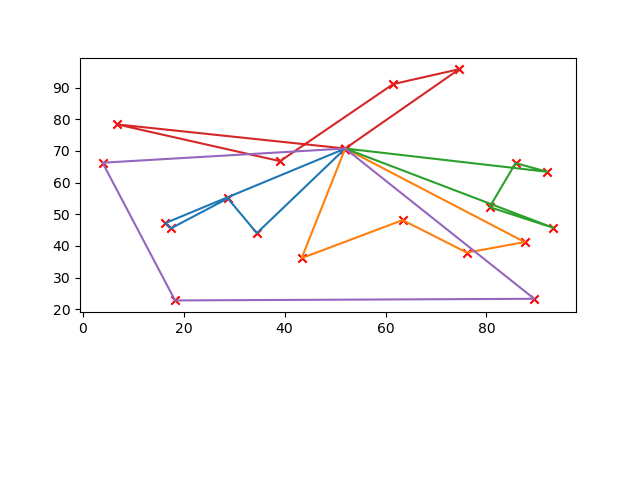

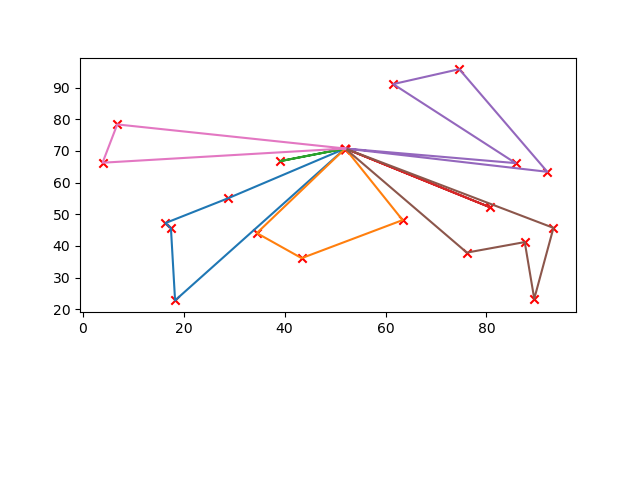

In [44]:
from solver_step import SolverStep
init_state = nearest_neighbour_solution(dists, demand, capacity)
init_step = SolverStep(init_state, eval_function(init_state),200)
print(init_state)
step_1 = solver_step(init_step)

print(step_1.get_best_sol())
print_path(points, init_step.get_best_sol())
print_path(points, step_1.get_best_sol())

# TESTE route removal

In [45]:
from proj_utils.fake_input_generator import generator
from VRP.greedy_solutions import nearest_neighbour_solution
from VRP.modify_solution_routes import remove_smallest_route
from VRP.modify_solution_routes import remove_random_route
from VRP.modify_solution_routes import split_biggest_route
from VRP.modify_solution_routes import split_random_route

dists, demand, points = generator(20)
path = nearest_neighbour_solution(dists, demand, (1,1))
print(path)

[0, 1, 0, 16, 0, 4, 0, 3, 0, 10, 0, 2, 0, 13, 0, 6, 0, 12, 0, 7, 0, 14, 0, 9, 0, 11, 0, 17, 0, 5, 0, 8, 0, 19, 0, 15, 0, 18, 0]


In [46]:
print(remove_smallest_route(path,len(dists),dists))

[0, 16, 1, 0, 4, 0, 3, 0, 10, 0, 2, 0, 13, 0, 6, 0, 12, 0, 7, 0, 14, 0, 9, 0, 11, 0, 17, 0, 5, 0, 8, 0, 19, 0, 15, 0, 18, 0]


In [47]:
print(remove_random_route(path,len(dists),dists))

[0, 1, 0, 16, 0, 4, 0, 3, 0, 10, 0, 2, 0, 13, 0, 6, 0, 12, 0, 7, 0, 14, 0, 9, 0, 11, 17, 0, 5, 0, 8, 0, 19, 0, 15, 0, 18, 0]


In [48]:
print(split_biggest_route(path,len(dists), dists))

[0, 1, 0, 16, 0, 4, 0, 3, 0, 10, 0, 2, 0, 13, 0, 6, 0, 12, 0, 7, 0, 14, 0, 9, 0, 11, 0, 17, 0, 5, 0, 8, 0, 19, 0, 15, 0, 18, 0]


In [49]:
print(split_random_route(path,len(dists), dists))

[0, 1, 0, 16, 0, 4, 0, 3, 0, 10, 0, 2, 0, 13, 0, 6, 0, 12, 0, 7, 0, 14, 0, 9, 0, 11, 0, 17, 0, 5, 0, 8, 0, 19, 0, 15, 0, 18, 0]
